# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


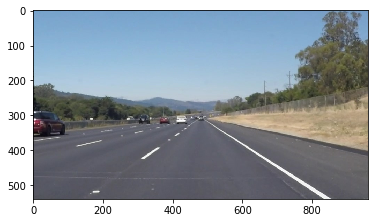

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #for line in lines:
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    # Initialize lists
    max_y = img.shape[0]
    min_y = img.shape[0]
    x_Left = []
    y_Left = []
    x_Right = []
    y_Right = []
    right_Slopes = []
    left_Slopes = []
    right_Intercepts = []
    left_Intercepts = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            
            # Find if slope is left or right based on positive or negative
            if slope < -0.5:
                left_Slopes.append(slope) 
                x_Left.append(x1)
                x_Left.append(x2)
                y_Left.append(y1)
                y_Left.append(y2)
                left_Intercepts.append(y1 - slope * x1)
            
            if slope > 0.5:
                right_Slopes.append(slope) 
                x_Right.append(x1)
                x_Right.append(x2)
                y_Right.append(y1)
                y_Right.append(y2)
                right_Intercepts.append(y1 - slope * x1)
            
            min_y = min(y1, y2, min_y)
    
    # Draw lines on left and right
    if len(left_Slopes) > 0:
        left_Slope = np.average(left_Slopes)
        left_Intercept = np.average(left_Intercepts)
        print(left_Intercept)
        min_x_Left = int((min_y - left_Intercept)/left_Slope) 
        max_x_Left = int((max_y - left_Intercept)/left_Slope)
        cv2.line(img, (min_x_Left, min_y), (max_x_Left, max_y), [255, 0, 0], 8)
    
    if len(right_Slopes) > 0:
        right_Slope = np.average(right_Slopes)
        right_Intercept = np.average(right_Intercepts)
        min_x_Right = int((min_y - right_Intercept)/right_Slope) 
        max_x_Right = int((max_y - right_Intercept)/right_Slope)
        cv2.line(img, (min_x_Right, min_y), (max_x_Right, max_y), [255, 0, 0], 8)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)



## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")


['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

703.067803389
637.260234328
666.069650232
675.560396352
645.049074891
679.872561946


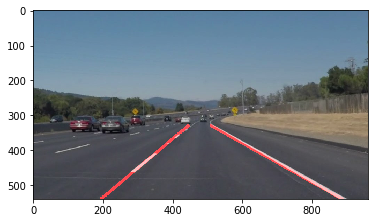

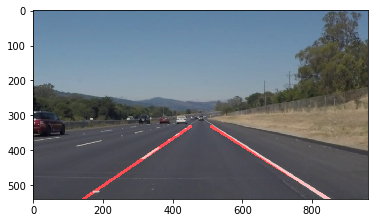

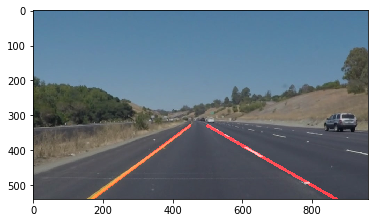

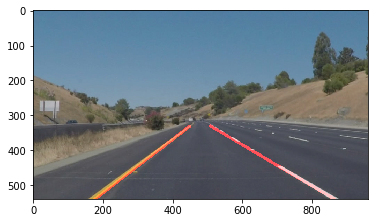

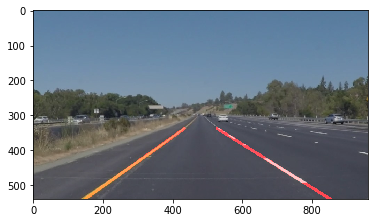

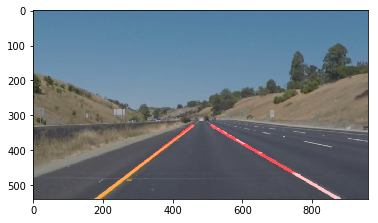

In [24]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def pipeline(img):

    # Step 1: Convert to grayscale
    gray = grayscale(img)

    # Step 2: Set kernel and apply Gaussian
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Step 3: Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    #plt.imshow(edges)


    # Step 4: Define a four sided polygon and mask 
    imshape = img.shape
    vertices = np.array([[(100,imshape[0]),(450, 330), (500, 330), (900,imshape[0])]], dtype=np.int32)

    masked_edges = region_of_interest(edges, vertices)


    # Step 5: Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20   # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10 #minimum number of pixels making up a line
    max_line_gap = 130    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Step 6: Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    lines_edges = weighted_img(lines, img, 0.8, 1., 0.)
    
    return lines_edges

# Create directory
output_directory = 'test_images_output'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Display images after pipeline and save   
for name in os.listdir("test_images/"):
    img = mpimg.imread('test_images/'+ name)
    after_pipeline = pipeline(img)
    plt.figure()
    plt.imshow(after_pipeline)
    mpimg.imsave(output_directory + '/' + name, after_pipeline)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    return result

In [16]:
#create test_videos_output
output_directory = 'test_videos_output'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

646.414458041
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  3%|▎         | 7/222 [00:00<00:03, 66.15it/s]

646.414458041
654.758950708
654.722655134
654.825249242
651.782314722
646.366228411
650.59771724
660.742569927
645.860131917
645.849521694
649.195060247
659.344617489
647.634303555


  7%|▋         | 15/222 [00:00<00:03, 67.22it/s]

646.601538908
642.613471593


 11%|█         | 24/222 [00:00<00:02, 71.39it/s]

649.105799076
646.708266798
635.102995791
638.022026464
654.832766709
649.275874487
647.804180592
654.499684271
628.453462213
649.676942505
649.15282328
649.644940522
653.276825792
643.357513608
654.507059801
645.74329514
648.495820934
645.318399587


 19%|█▉        | 42/222 [00:00<00:02, 77.90it/s]

645.604114825
656.998229668
648.251874974
645.525043576
660.587397958
660.459001916
637.453594673
647.572793768
645.246955985
650.792682136
645.965858337
648.410685086
663.925319577
653.251001286


 22%|██▏       | 49/222 [00:00<00:02, 57.88it/s]

649.832406006
655.530665844
662.104855239
637.957010181
637.12542478


 25%|██▍       | 55/222 [00:00<00:03, 54.05it/s]

645.470682533
648.611111111
630.943778645


 27%|██▋       | 61/222 [00:01<00:03, 49.63it/s]

637.271153903
639.054068541
623.787739048
622.371785582
640.345709479
651.171059601
639.486683373
627.273479026
637.356576143


 30%|███       | 67/222 [00:01<00:03, 41.58it/s]

628.836493358
615.992592593
620.540555022
630.497134277
629.866768182


 32%|███▏      | 72/222 [00:01<00:03, 39.55it/s]

627.281321695
618.843553154
633.569957117


 35%|███▍      | 77/222 [00:01<00:03, 37.57it/s]

626.077449513
625.254056059
627.056062313
625.04345483
622.050815765
631.735338346
612.399038462
616.83029382
640.244942662


 38%|███▊      | 85/222 [00:01<00:03, 36.99it/s]

600.522298393
622.608518473
624.669603924
610.734675508


 40%|████      | 89/222 [00:01<00:03, 36.26it/s]

621.468979384
620.890178953
622.059133831
622.217344196


 42%|████▏     | 93/222 [00:01<00:03, 35.23it/s]

620.682601881
615.161609518
625.608431621
622.883503043


 44%|████▎     | 97/222 [00:02<00:03, 35.18it/s]

629.749862545
626.763076959
625.919035948
627.685734723


 45%|████▌     | 101/222 [00:02<00:03, 35.63it/s]

624.50118792
621.918738855
615.102773354
618.531848984


 47%|████▋     | 105/222 [00:02<00:03, 34.97it/s]

619.168959259
635.884881292
630.452371902
631.341632505
621.893457547
635.367069379
640.46555128
633.568410986


 52%|█████▏    | 115/222 [00:02<00:02, 38.97it/s]

636.81603646
637.561857001
644.021802084
630.957036605
625.682079613
637.167961245
635.550510813
632.525662387
618.11149864


 56%|█████▌    | 124/222 [00:02<00:02, 38.94it/s]

613.266799696
614.707133942
636.331688388
637.236110583
633.29947139
618.13252258
635.129064386
618.899687022


 60%|█████▉    | 133/222 [00:02<00:02, 39.17it/s]

641.244055665
637.697501367
640.33471426
644.583381622
642.41072582
652.172394485
654.4452724
650.400544408
657.961796141
643.401259087


 62%|██████▏   | 138/222 [00:03<00:02, 41.15it/s]

650.84137832
642.878267612
639.650758474
647.538369385
645.264329839
651.754396968


 64%|██████▍   | 143/222 [00:03<00:01, 39.98it/s]

652.8802609
646.006736539
654.750794288


 67%|██████▋   | 148/222 [00:03<00:01, 41.02it/s]

666.389341584
635.414344272
656.227877377
657.081707088
656.724921342
651.805542974
658.68802202


 69%|██████▉   | 153/222 [00:03<00:01, 42.17it/s]

654.828986568
651.917947214
639.495132264


 71%|███████   | 158/222 [00:03<00:01, 43.48it/s]

656.993558986
650.311370057
666.214477865
650.211077983
671.369081584
663.950300748
670.066412176

 73%|███████▎  | 163/222 [00:03<00:01, 42.83it/s]


670.593009541


 76%|███████▌  | 168/222 [00:03<00:01, 41.38it/s]

676.087988827
668.035425756
678.28944896
668.543925996
677.07861491
690.63916742
685.870356817
688.504621179
693.488773222


 80%|████████  | 178/222 [00:04<00:01, 41.39it/s]

681.73802194
677.452150538
688.349608249
688.636615899
678.363749542
689.276510356
693.819506793
711.069577486
701.712563292
694.967605962


 83%|████████▎ | 184/222 [00:04<00:00, 43.87it/s]

707.44540675
674.006080919
695.040950155
694.980654054
686.174761157
691.295983283


 85%|████████▌ | 189/222 [00:04<00:00, 42.88it/s]

685.359746751
685.230785347
689.839126329
688.155255634


 87%|████████▋ | 194/222 [00:04<00:00, 44.56it/s]

690.159860979
691.987345741
686.082006229
684.287950303
687.543264721
694.632795038


 90%|████████▉ | 199/222 [00:04<00:00, 45.18it/s]

694.525806156
700.646434332
703.857285817
688.265069272


 92%|█████████▏| 204/222 [00:04<00:00, 41.03it/s]

702.205174582
690.743839807
685.551255237
713.15560868


 94%|█████████▍| 209/222 [00:04<00:00, 42.23it/s]

699.196713726
694.604865792
691.382733407
687.246316368


 96%|█████████▋| 214/222 [00:04<00:00, 43.19it/s]

689.25981558
678.658044159
680.414793855
680.866814464
677.535003159
689.353709972
668.534080746


 99%|█████████▉| 220/222 [00:04<00:00, 45.68it/s]

682.891155097
689.326498877
679.037851696


100%|█████████▉| 221/222 [00:05<00:00, 44.04it/s]


671.894026973
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.65 s, sys: 746 ms, total: 3.39 s
Wall time: 5.65 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [18]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

609.149181403
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 7/682 [00:00<00:10, 62.68it/s]

609.149181403
610.677644804
617.235774658
616.248853815
615.339454978
613.619015366
618.623350493
639.347030656
609.249491002
615.158494585
632.03194601
633.717865301
622.8181483
634.946151764
620.011819935


  3%|▎         | 23/682 [00:00<00:09, 68.87it/s]

634.669838842
629.651555793
633.789148323
650.795554051
637.658120744
654.774711796
647.604226141
644.463335292
632.377689149
632.042696557
635.586945095
659.91384567
652.722747216
632.79684571


  5%|▍         | 32/682 [00:00<00:08, 72.31it/s]

654.723102606
644.260362783
634.347406327


  6%|▌         | 41/682 [00:00<00:08, 75.61it/s]

657.311883875
658.049368197
659.092514218
653.264772123
655.246037553
642.821532759
649.599635622
647.36294917
639.201784835
650.760305326
651.978935936
649.289369933
644.160386583
662.214951482
653.357913293


  7%|▋         | 48/682 [00:00<00:10, 59.15it/s]

653.712454385
648.15364167
651.269309673
654.515401929
645.312556828


  8%|▊         | 54/682 [00:00<00:12, 51.59it/s]

650.744111685
650.411996679
659.202145823


  9%|▉         | 60/682 [00:01<00:12, 49.31it/s]

643.809876292
648.472838205
644.411596479
660.926567541
648.286358852
646.144220244
643.284436615
641.343928912
644.183972744
639.240937066


 10%|█         | 71/682 [00:01<00:12, 47.26it/s]

625.131845065
642.479344793
644.230975995
642.351836653
643.380596258
661.839544067
643.670022689
639.257589118
626.490214107


 11%|█         | 76/682 [00:01<00:15, 39.08it/s]

644.02443788
635.701024713
638.427907474
649.156818118
638.707352398
647.105913787


 12%|█▏        | 81/682 [00:01<00:15, 39.61it/s]

642.098165098
653.049347544


 13%|█▎        | 86/682 [00:01<00:15, 38.48it/s]

646.723929845
636.381774757
639.707965603
649.720610726
643.066430352
632.072213308
633.815424162
632.59365769
635.577904668


 14%|█▍        | 96/682 [00:01<00:13, 42.86it/s]

653.120755268
636.826617484
636.461030239
633.414087417
639.946929637
639.64028821
659.048543927
640.373235645
640.438228295


 16%|█▌        | 106/682 [00:02<00:14, 41.00it/s]

643.835563545
638.075140905
637.746955164
637.231656969
636.209149917
641.798004838
637.496801741
653.849832948
636.52874869


 17%|█▋        | 116/682 [00:02<00:13, 42.11it/s]

628.991063502
629.010488916
640.254109651
630.862283458
639.503961873
647.532318917
641.714146035
638.409176932
637.178481542
666.109544324


 18%|█▊        | 126/682 [00:02<00:12, 44.31it/s]

652.432928394
638.129384159
632.962573784
657.797058139
647.543363949
645.058760432
656.423968956
649.826263709
648.877247453
659.279726503


 20%|█▉        | 136/682 [00:02<00:12, 45.48it/s]

648.352681359
646.357098149
646.725488707
645.933220468
645.858915506
646.100084301
640.141319572
647.009219483
640.274903775
654.20222611


 21%|██▏       | 146/682 [00:03<00:11, 45.65it/s]

652.917330315
649.613336046
646.006897543
658.1077242
640.116477317
643.11195835
652.660580314
646.386483834
650.340898923
649.482122886


 23%|██▎       | 156/682 [00:03<00:11, 45.59it/s]

656.375298652
655.959775212
661.679335013
645.220507126
664.207539085
633.234562745
667.077642692
648.345397433
648.41992527
646.271201847


 24%|██▍       | 166/682 [00:03<00:11, 43.74it/s]

667.366581978
652.834020271
683.28013091
657.578029415
686.251605795
656.814311316
656.348243032
651.405712449


 25%|██▌       | 171/682 [00:03<00:12, 41.10it/s]

659.663318546
655.558524894
660.19234791
664.409588362
660.33917887
676.581917083
663.719943406


 26%|██▌       | 176/682 [00:03<00:12, 39.80it/s]

662.402267246
659.721984056


 27%|██▋       | 181/682 [00:03<00:12, 41.52it/s]

676.584741745
668.399046107
678.076652704
673.537768578
678.238631502
670.150112329
662.567960306
689.958257722


 27%|██▋       | 186/682 [00:03<00:11, 42.92it/s]

678.351923311
690.00475585
671.433094417
685.893734018
693.453537731
679.072852061


 28%|██▊       | 191/682 [00:04<00:13, 36.74it/s]

677.675768865
684.45154508


 29%|██▊       | 195/682 [00:04<00:14, 34.11it/s]

694.531937173
666.820816626
687.324227954
678.443390078
688.440226961


 29%|██▉       | 199/682 [00:04<00:14, 33.78it/s]

670.661906459
693.706441531


 30%|██▉       | 203/682 [00:04<00:14, 33.76it/s]

653.926282975
684.19769171
672.714902548
691.666807822
679.38098674
673.324078582
667.698808401


 31%|███       | 211/682 [00:04<00:13, 33.84it/s]

669.068122789
664.952683131
693.504851872
665.451591389
662.340843047
662.951763931
655.85620807


 32%|███▏      | 220/682 [00:05<00:13, 35.24it/s]

683.647223549
655.840588375
664.881030239
677.053499825
652.76062163
657.083190583
659.391907714
664.221683965
656.435103309


 34%|███▎      | 230/682 [00:05<00:11, 39.22it/s]

669.197532005
650.207201921
658.562608572
669.539976033
655.302336214
664.363733766
662.792923728
655.515266697
659.583410236
651.599411538


 35%|███▌      | 240/682 [00:05<00:10, 42.72it/s]

651.304685547
647.867197447
662.860931402
641.358400026
647.226288239
652.819071734
649.092071994
649.437766151
647.627932785
643.360888171


 36%|███▌      | 245/682 [00:05<00:11, 38.44it/s]

655.160726064
650.613922835
646.261168103
642.141570986
674.21756195
637.94899646


 37%|███▋      | 254/682 [00:05<00:11, 36.28it/s]

633.14197807
642.223543296
649.027869321
648.83028199
645.585355732
641.191962194
647.938725209
667.592002642
659.511954373


 38%|███▊      | 262/682 [00:06<00:11, 36.45it/s]

663.466844211
664.395730571
669.816145891
649.711560829
647.310588651
665.958599144
653.765660847
650.78422764


 40%|███▉      | 271/682 [00:06<00:10, 37.93it/s]

649.632818033
650.158186781
650.4456477
648.551692273
650.443899112
652.379437099
650.06005114
650.928582005


 41%|████      | 279/682 [00:06<00:11, 35.43it/s]

653.596895615
653.649446871
654.921795981
654.354284545
658.532907181
652.132948599
639.363125407


 41%|████▏     | 283/682 [00:06<00:11, 34.48it/s]

655.451162542
649.442397615
641.790688338
666.755789376
660.366187289
660.287293806
657.962840693
654.40084282


 43%|████▎     | 292/682 [00:06<00:10, 35.99it/s]

665.839427726
657.855686366
680.969696394
679.441202492
662.65867137
663.274421332
660.68901978


 44%|████▍     | 301/682 [00:07<00:10, 34.73it/s]

663.05424344
663.16696922
640.113423811
648.715798545
655.33839815
649.706091317
656.580363019
666.7312001
651.839508463


 45%|████▌     | 310/682 [00:07<00:10, 36.73it/s]

653.02657738
661.741649268
677.939098715
653.932421822
660.908760154
664.389991435
648.706426206
641.213106388
635.93834231


 47%|████▋     | 320/682 [00:07<00:08, 40.35it/s]

645.512847486
644.107781269
651.754105075
654.332482034
645.767354355
656.645462781
652.112748672
667.945412862
652.239813518


 48%|████▊     | 330/682 [00:07<00:08, 40.49it/s]

657.378036031
659.832912546
652.670506799
642.797662152
646.276738376
646.677524967
661.697280255
641.955488743
655.836164496


 50%|████▉     | 340/682 [00:08<00:08, 42.24it/s]

648.645028229
652.221281844
647.962604445
642.089745865
643.346131304
639.12942095
638.344304138
637.842447174
631.782420985


 51%|█████     | 345/682 [00:08<00:07, 43.57it/s]

638.568146333
634.955030805
637.566638951
638.387242661
635.131234252
638.006407087
641.247992612
638.947882205
642.024355706


 52%|█████▏    | 356/682 [00:08<00:07, 43.27it/s]

640.064213978
642.538926082
624.506249499
645.896817995
636.129393112
644.17263268
637.127219514
664.249967759
630.365141286
630.334294373


 54%|█████▎    | 366/682 [00:08<00:07, 44.22it/s]

637.983159411
629.82829517
652.786750483
647.072405484
640.876273928
653.378510369
634.149315906
646.65929037
646.569354769
655.159516713


 55%|█████▌    | 376/682 [00:08<00:06, 45.41it/s]

650.575331664
641.025247361
636.071819386
640.019766645
647.595810873
658.059567784
646.262067491
641.818416233
640.405704041
641.544021539


 57%|█████▋    | 386/682 [00:09<00:06, 45.42it/s]

637.082215565
641.202922542
644.572587822
642.305054255
646.358290416
650.970546194
646.169805278
636.707508092
636.59449077
628.780316652


 58%|█████▊    | 396/682 [00:09<00:06, 47.30it/s]

635.765111821
637.822578593
636.996789001
638.323348435
637.998192946
637.922135662
635.959577261
637.109579344
634.087857363
624.997043617


 60%|█████▉    | 406/682 [00:09<00:05, 47.04it/s]

633.218561865
640.909242245
647.864533437
646.006815382
639.23357468
651.229123147
634.383324292
643.144120742
624.117911078
643.739187725


 61%|██████    | 416/682 [00:09<00:05, 45.88it/s]

628.672468383
643.144098802
638.335226476
635.635015406
637.544871499
636.859289846
636.123348451
636.89390795
635.548877741
634.456443571
647.849984936


 63%|██████▎   | 427/682 [00:10<00:05, 47.36it/s]

639.019883536
636.21554386
634.873858687
636.962351759
627.676186956
630.258668265
640.221606376
638.951037619
639.33353189
640.040288426


 64%|██████▍   | 437/682 [00:10<00:05, 46.93it/s]

639.87127266
635.269280394
638.648497934
638.163479753
639.825861953
635.654459763
637.930983737
637.355690688
633.031614366
632.587795744


 66%|██████▌   | 447/682 [00:10<00:04, 47.56it/s]

631.915290208
632.623254161
631.999179038
631.20612842
635.298558582
631.276124921
626.258849833
630.315634775
636.873186213
630.629595877


 67%|██████▋   | 457/682 [00:10<00:04, 46.62it/s]

646.139620214
636.531359911
631.918985082
635.026010487
617.724012849
632.911609193
624.902515971
627.833179878
622.106988039
624.319918312


 69%|██████▊   | 468/682 [00:10<00:04, 46.43it/s]

627.51571268
625.778875692
637.639666947
658.192882466
660.006680783
645.857987345
642.600242925
633.952549994
643.44327116
628.711340955


 70%|███████   | 478/682 [00:11<00:04, 46.81it/s]

624.955983423
625.983678291
638.484678232
654.101829845
631.526605055
629.929550863
638.764098625
637.621679814
638.309971886
638.731613807
637.231293345


 72%|███████▏  | 488/682 [00:11<00:04, 46.14it/s]

651.48294815
645.880293202
634.710392697
638.848866462
630.453104631
627.932627384
633.220401988
619.322478906
619.446038465
638.272862151


 73%|███████▎  | 499/682 [00:11<00:03, 46.37it/s]

637.897411917
638.279332675
648.259988001
620.190899318
642.24103279
644.035280516
633.227409802
648.071375892
644.512099994
635.841113471


 75%|███████▍  | 509/682 [00:11<00:03, 47.25it/s]

634.588312576
639.282432961
641.490238656
641.136537408
661.854455023
641.899299391
663.245909227
652.784102753
633.443076685


 76%|███████▌  | 519/682 [00:12<00:03, 45.91it/s]

632.803369818
644.190733647
640.27361852
630.758391184
638.93899079
632.466196554
647.166911041
648.837933743
630.309565589
662.86897201


 78%|███████▊  | 529/682 [00:12<00:03, 45.10it/s]

623.874717417
657.866107253
631.050855085
646.86188435
630.465958372
631.300439381
636.515415431
641.99688953
631.514098797
635.440785933


 79%|███████▉  | 539/682 [00:12<00:03, 46.66it/s]

640.582401237
648.485446533
629.977427196
685.273497739
656.934923134
669.425155904
666.206299807
657.73102978
640.737770932
644.055469192
645.452187259


 81%|████████  | 550/682 [00:12<00:02, 48.06it/s]

642.133283204
644.129765655
643.901711752
639.131292979
644.147528012
631.552683639
642.176748794
638.304832198
644.860975028
649.420828467
636.388949779


 82%|████████▏ | 560/682 [00:12<00:02, 46.96it/s]

663.19706476
648.639609779
651.581355404
652.53927488
658.981726345
642.403974846
656.420088364
657.768130443
657.347911249
643.906681104


 84%|████████▎ | 570/682 [00:13<00:02, 45.87it/s]

649.63782462
650.68930187
654.158112128
652.013505746
666.012411565
652.33314277
658.771345403
660.699895299
639.609030726
681.144655702


 85%|████████▌ | 580/682 [00:13<00:02, 45.92it/s]

675.81174089
683.926128874
663.917761646
665.544242303
669.358365094
674.947652179
677.323210487
651.9105274
665.580806955
667.158529437


 87%|████████▋ | 590/682 [00:13<00:02, 44.43it/s]

683.731256912
665.631223527
660.752389882
673.524492246
683.524289904
660.606258093
651.054203868
667.470424055
687.125982014
657.344157502


 88%|████████▊ | 601/682 [00:13<00:01, 46.69it/s]

634.398016518
691.821506861
672.02531259
674.299924869
687.890814529
676.548381613
676.48468877
665.948353626
672.039420671
689.565771414


 90%|████████▉ | 612/682 [00:14<00:01, 46.74it/s]

675.19779673
670.729805604
677.906425043
673.557558005
705.860711431
681.680427848
690.773255992
653.504300819
683.835495292
677.082355007


 91%|█████████ | 622/682 [00:14<00:01, 46.75it/s]

673.576145112
691.872314488
683.516969769
687.815928519
711.224052252
677.94216868
678.638969187
734.029603789
698.542275469
698.335747618


 93%|█████████▎| 633/682 [00:14<00:01, 47.43it/s]

689.513236584
701.728080575
703.56429309
676.933375753
715.453044825
691.635610045
694.381541612
694.152941076
712.931416497
687.012430235
691.581646618


 94%|█████████▍| 643/682 [00:14<00:00, 47.66it/s]

696.325959055
731.386402135
696.997583718
700.573043638
688.808823849
730.839597746
685.362579007
676.623425029
672.638347248
668.161199724


 96%|█████████▌| 653/682 [00:14<00:00, 46.69it/s]

673.469424072
681.361089475
689.320453318
683.945839852
694.424202005
689.23066525
693.134304188
668.794625439
681.786548127
673.472993165


 97%|█████████▋| 663/682 [00:15<00:00, 47.35it/s]

681.559794762
681.569882042
661.220601768
660.32738077
682.409683243
671.673598727
667.429674627
661.640886204
666.20627911
665.092501937


 99%|█████████▊| 673/682 [00:15<00:00, 46.60it/s]

672.451067497
669.187767318
645.494481775
669.232155678
649.178625561
655.042830456
654.120513781
650.66909495
648.360828177
647.785710776
657.396742496


100%|█████████▉| 681/682 [00:15<00:00, 43.87it/s]


653.362025802
656.414108169
656.374756378
659.473081562
658.394418773
663.421749402
685.79384321
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 8.41 s, sys: 2.12 s, total: 10.5 s
Wall time: 16.2 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))